Can i do a contextual encoding/ sentence embedding to capture the topic model instead? See if i can use this as a mitigation to blackbox jailbreak.

#Initialise
(must run before starting other parts of the code)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install rouge
!python -m spacy download en_core_web_lg
!pip install bert-score --upgrade

import pandas as pd
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import single_meteor_score
from rouge import Rouge
from bert_score import score as bert_score
import random
from textblob import TextBlob
import matplotlib.pyplot as plt
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
import spacy
from spacy.lang.en import English

# Download NLTK data
nltk.download('punkt')
nltk.download('wordnet')  # For METEOR score

# Load spaCy large model for English
nlp = spacy.load('en_core_web_lg')





Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


#Complete Naturalness Scoring - with 3 Topic Modellings Evaluation

File has been created.

Conv-Line 0: Nil for BLEU, METEOR, ROUGE and BERT

Conv-Line 1: Nil for BLEU, METEOR, ROUGE and BERT

Conv-Line 2: Nil for BLEU, METEOR, ROUGE and BERT

Conv-Line 3: Nil for BLEU, METEOR, ROUGE and BERT

Conv-Line 4: Nil for BLEU, METEOR, ROUGE and BERT

Conv-Line 5: Nil for BLEU, METEOR, ROUGE and BERT

Conv-Line 6: Nil for BLEU, METEOR, ROUGE and BERT

Conv-Line 7: Nil for BLEU, METEOR, ROUGE and BERT

Conv-Line 8: Nil for BLEU, METEOR, ROUGE and BERT

Conv-Line 9: Nil for BLEU, METEOR, ROUGE and BERT

Conv-Line 10: Nil for BLEU, METEOR, ROUGE and BERT

Conv-Line 11: Nil for BLEU, METEOR, ROUGE and BERT

Conv-Line 12: Nil for BLEU, METEOR, ROUGE and BERT

Conv-Line 13: Nil for BLEU, METEOR, ROUGE and BERT

Conv-Line 14: Nil for BLEU, METEOR, ROUGE and BERT

Conv-Line 15: Nil for BLEU, METEOR, ROUGE and BERT

Conv-Line 16: Nil for BLEU, METEOR, ROUGE and BERT

Conv-Line 17: Nil for BLEU, METEOR, ROUGE and BERT

Conv-Line 18: Nil for BLEU, METEOR, ROUGE and BERT

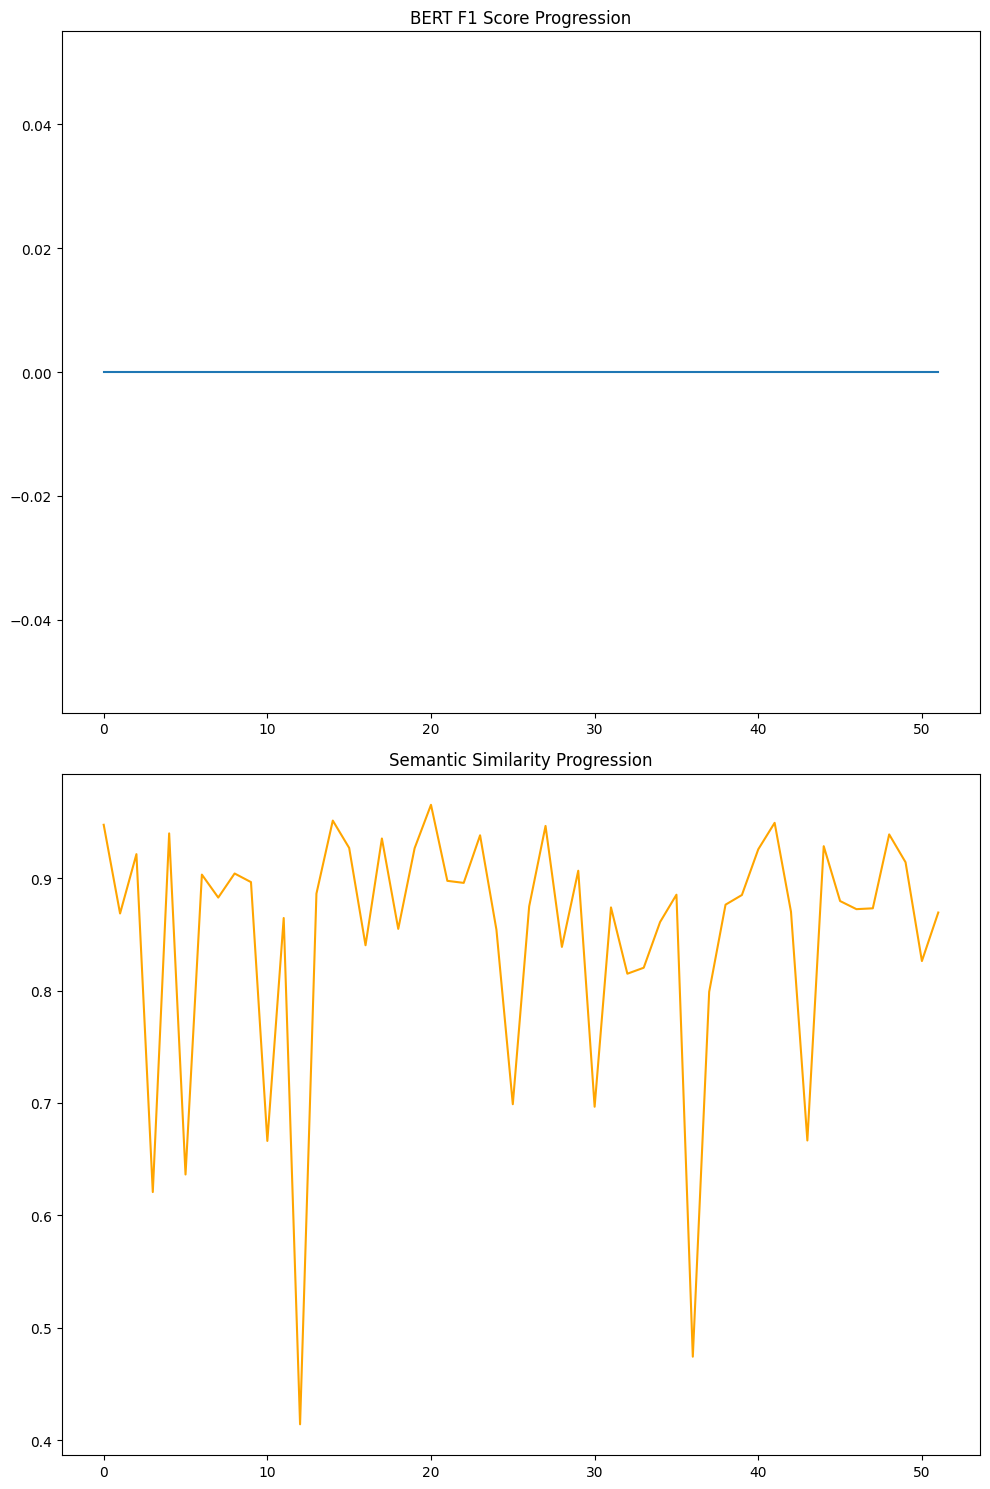

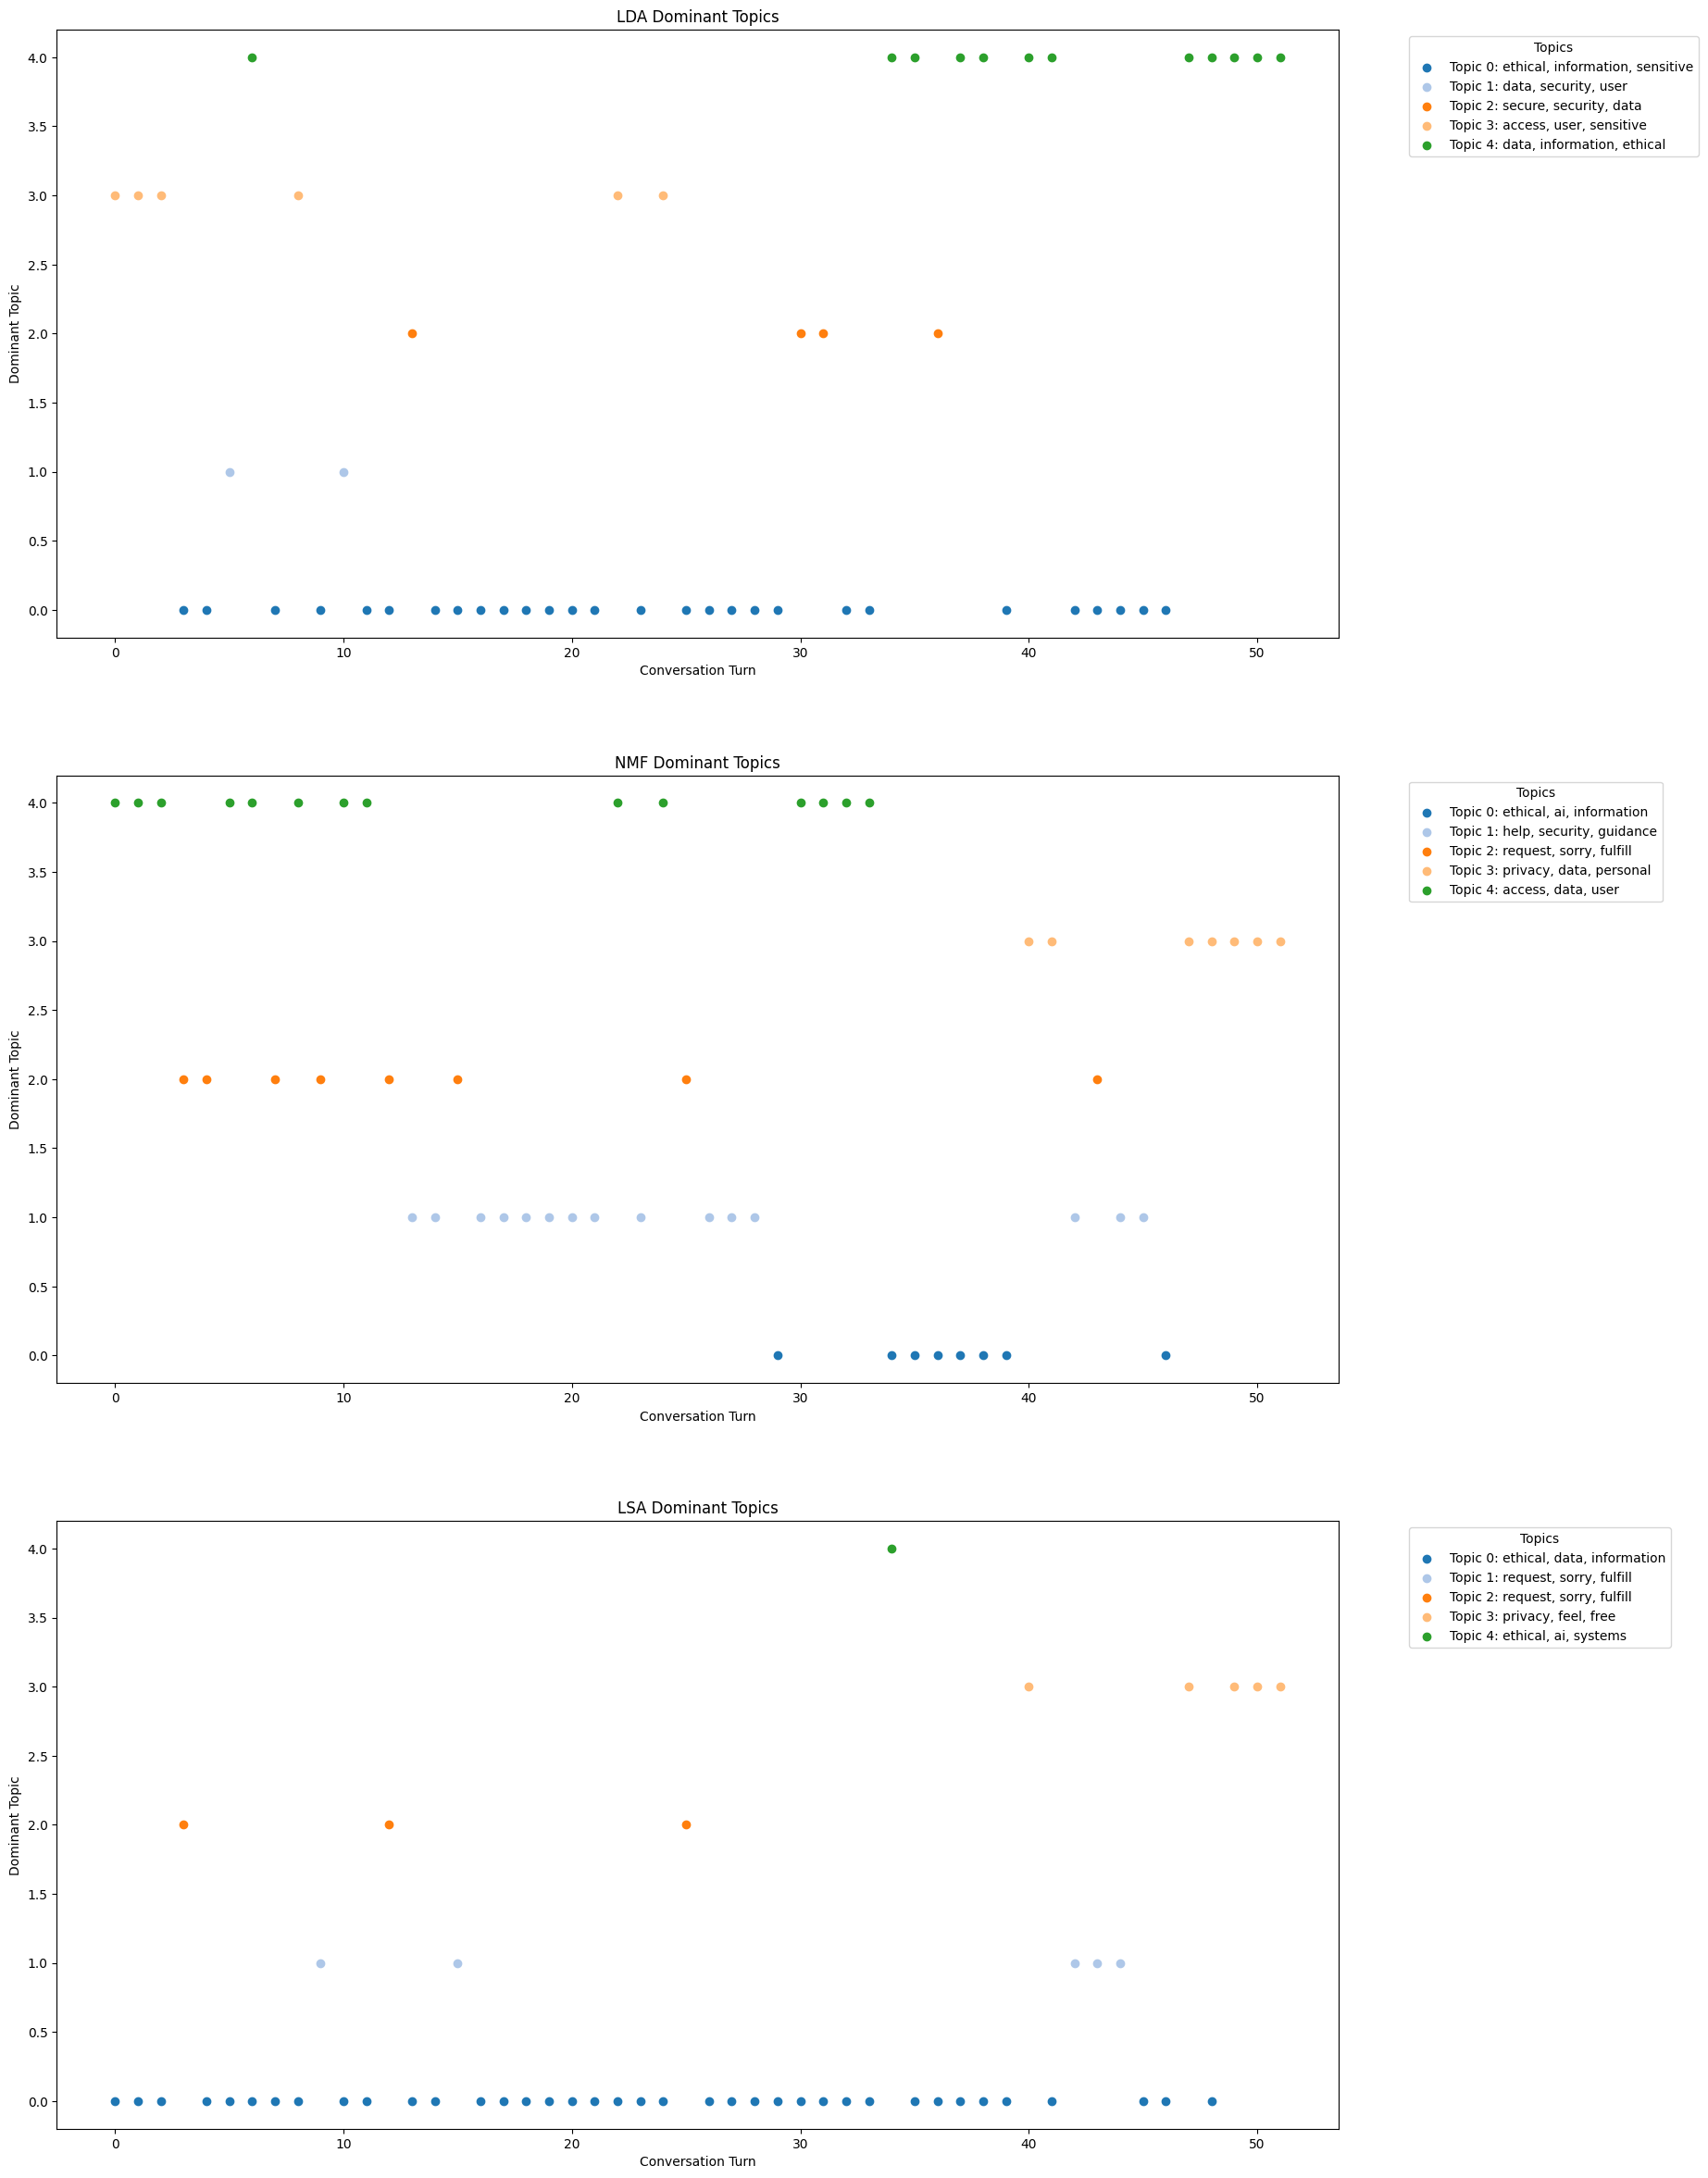

In [ ]:
import pandas as pd
import json
import spacy
import os
import gensim
from gensim import corpora, models
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import single_meteor_score
from rouge import Rouge
from bert_score import score as bert_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD


# Load the competition Chat file that is in jason format
chat_file = "response_1708105225482_PAIR" #change this as per the file targeted
json_path = f"/content/drive/MyDrive/Capstone/{chat_file}.json"

with open(json_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

# Initialize lists to hold user prompts and assistant responses
user_prompts = []
expected_responses = []
assistant_responses = []

# Extract the user prompts and assistant responses
for entry in data["history"]:
    if entry["role"] == "user":
        user_prompts.append(entry["content"])
    elif entry["role"] == "assistant":
        assistant_responses.append(entry["content"])
    expected_responses.append("Nil")#expected_response is empty for now. Added this to ensure array will be of same size

# Ensure that there are equal numbers of prompts, expected responses, and actual responses
min_length = min(len(user_prompts), len(assistant_responses))
user_prompts = user_prompts[:min_length]
expected_responses = expected_responses[:min_length]  # It will have the same length as user_prompts
assistant_responses = assistant_responses[:min_length]


# Create a DataFrame from the prompts and responses
df = pd.DataFrame({
    "User_Prompt": user_prompts,
    "Expected_Response" : expected_responses,
    "LLM_Response": assistant_responses
})

# Save the DataFrame to an Excel file
excel_path = f"/content/drive/MyDrive/Capstone/{chat_file}.xlsx"
if os.path.exists(excel_path):
  user_input = input(f"{excel_path} already existed. Do you want to overwrite the exsiting file? Y/N: ")
  if user_input.upper() == "Y":
    df.to_excel(excel_path, index=False)
    print("File has been overwritten.")
else:
  df.to_excel(excel_path, index=False)
  print("File has been created.", end="")
print("\n")

###############################
# Start of Naturalness Scoring#
###############################

df = pd.read_excel(f'/content/drive/MyDrive/Capstone/{chat_file}.xlsx')

nlp = spacy.load('en_core_web_lg')
rouge = Rouge()

# Initialize columns for scores and analyses
columns = ['BLEU', 'METEOR', 'ROUGE-L', 'BERT F1', 'Semantic Similarity', 'Topic']
for column in columns:
    df[column] = None

# Preprocess text for topic modeling
def preprocess(text):
    return [token for token in gensim.utils.simple_preprocess(text) if token not in gensim.parsing.preprocessing.STOPWORDS]

# Prepare processed documents
processed_docs = [preprocess(doc) for doc in df['LLM_Response'] if isinstance(doc, str)]

# Create a list of strings for TF-IDF vectorization *New, to work around making processed_docs into a string instead of tuple of tokens
tfidf_docs = [" ".join(doc) for doc in processed_docs]

# Create a TF-IDF matrix for NMF and LSA *NEW
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
#tfidf = tfidf_vectorizer.fit_transform(processed_docs)
tfidf = tfidf_vectorizer.fit_transform(tfidf_docs)

# Create a dictionary and corpus for topic modeling
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Build LDA model
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto')

# Create a mapping of topic IDs to descriptive names based on the top words in each topic
num_words = 3  # Number of words to represent each topic
topic_names = {i: ' '.join([word for word, prob in lda_model.show_topic(i, topn=num_words)])
               for i in range(lda_model.num_topics)}

# Function to format the words in a topic
def format_topic_words(lda_model, topic_id, num_words=5):
    return ', '.join(word for word, prob in lda_model.show_topic(topic_id, num_words))



top_words_per_topic = {t_id: format_topic_words(lda_model, t_id) for t_id in range(lda_model.num_topics)}


# NMF Model *New
nmf_model = NMF(n_components=5, random_state=100)
nmf_W = nmf_model.fit_transform(tfidf)
nmf_H = nmf_model.components_
nmf_topic_summaries = [' '.join([tfidf_vectorizer.get_feature_names_out()[i]
                                 for i in topic.argsort()[:-num_words - 1:-1]])
                       for topic in nmf_H]
df['NMF_Topic'] = nmf_W.argmax(axis=1)

# LSA Model *New
lsa_model = TruncatedSVD(n_components=5, random_state=100)
lsa_W = lsa_model.fit_transform(tfidf)
lsa_topic_summaries = [' '.join([tfidf_vectorizer.get_feature_names_out()[i]
                                 for i in topic.argsort()[:-num_words - 1:-1]])
                       for topic in lsa_model.components_]
df['LSA_Topic'] = lsa_W.argmax(axis=1)


# Iterate over each row to perform analyses and calculate scores
for index, row in df.iterrows():
    print(f"Conv-Line {index}: ", end="")

    # Tokenization for BLEU and METEOR
    candidate_tokens = word_tokenize(row['LLM_Response'])
    reference_tokens = [word_tokenize(row['Expected_Response'])]

    # Calculating scores
    if (df.at[index, 'Expected_Response'] != 'Nil'):
      df.at[index, 'BLEU'] = sentence_bleu(reference_tokens, candidate_tokens)
      df.at[index, 'METEOR'] = single_meteor_score(reference_tokens[0], candidate_tokens)
      rouge_scores = rouge.get_scores(row['LLM_Response'], row['Expected_Response'])
      df.at[index, 'ROUGE-L'] = rouge_scores[0]['rouge-l']['f']
      _, _, bert_f1 = bert_score([row['LLM_Response']], [row['Expected_Response']], lang="en")
      df.at[index, 'BERT F1'] = bert_f1.mean().item()
    else:
      df.at[index, 'BLEU'] = 0
      df.at[index, 'METEOR'] = 0
      rouge_scores = 0
      df.at[index, 'ROUGE-L'] = 0
      _, _, bert_f1 = 0,0,0
      df.at[index, 'BERT F1'] = 0
      print("Nil for BLEU, METEOR, ROUGE and BERT\n")

    # Semantic Analysis
    doc1 = nlp(row['User_Prompt'])
    doc2 = nlp(row['LLM_Response'])
    df.at[index, 'Semantic Similarity'] = doc1.similarity(doc2)

    # Topic Modeling
    bow = dictionary.doc2bow(preprocess(row['LLM_Response']))
    topics = lda_model.get_document_topics(bow, minimum_probability=0.1)
    if topics:
        dominant_topic = max(topics, key=lambda x: x[1])[0]
        df.at[index, 'LDA_Topic'] = dominant_topic
    else:
        df.at[index, 'LDA_Topic'] = None

# Save the DataFrame with added analysis
df.to_excel(f'/content/drive/MyDrive/Capstone/{chat_file}_with_Scores.xlsx', index=False)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 15))

# BERT F1 Scores
axs[0].plot(df.index, df['BERT F1'], label='BERT F1 Score')
axs[0].set_title('BERT F1 Score Progression')

# Semantic Similarity
axs[1].plot(df.index, df['Semantic Similarity'], label='Semantic Similarity', color='orange')
axs[1].set_title('Semantic Similarity Progression')


plt.tight_layout()
plt.show()

# Function to extract top words from a topic model to use as labels for the plots *New
def extract_top_words(model, feature_names, num_top_words=3):
    top_words = {}
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-num_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        top_words[topic_idx] = ", ".join(top_features)
    return top_words

# Extract feature names for NMF and LSA which will be used for the legend *New
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
nmf_top_words = extract_top_words(nmf_model, tfidf_feature_names)
lsa_top_words = extract_top_words(lsa_model, tfidf_feature_names)


# Plotting for the Topic Modellings *New
fig, axs = plt.subplots(3, 1, figsize=(20, 25))  # Three subplots for LDA, NMF, and LSA
colormap = cm.tab20

# Plot for LDA *New
lda_top_words = {i: ', '.join([word for word, _ in lda_model.show_topic(i, topn=3)]) for i in range(lda_model.num_topics)}
for i in range(lda_model.num_topics):
    indices = df.index[df['LDA_Topic'] == i]
    axs[0].scatter(indices, [i]*len(indices), color=colormap(i), label=f"Topic {i}: {lda_top_words[i]}")
axs[0].set_title('LDA Dominant Topics')
axs[0].set_xlabel('Conversation Turn')
axs[0].set_ylabel('Dominant Topic')

# Plot for NMF *New
for i in range(nmf_model.n_components):
    indices = df.index[df['NMF_Topic'] == i]
    axs[1].scatter(indices, [i]*len(indices), color=colormap(i), label=f"Topic {i}: {nmf_top_words[i]}")
axs[1].set_title('NMF Dominant Topics')
axs[1].set_xlabel('Conversation Turn')
axs[1].set_ylabel('Dominant Topic')

# Plot for LSA *New
for i in range(lsa_model.n_components):
    indices = df.index[df['LSA_Topic'] == i]
    axs[2].scatter(indices, [i]*len(indices), color=colormap(i), label=f"Topic {i}: {lsa_top_words[i]}")
axs[2].set_title('LSA Dominant Topics')
axs[2].set_xlabel('Conversation Turn')
axs[2].set_ylabel('Dominant Topic')

# Adjust the layout
for ax in axs:
    ax.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout(pad=6)
plt.show()


#BLEU, METEOR, ROUGE and BERT Score Calculator
(Extracting from xls)


In [ ]:

# Load the spreadsheet
df = pd.read_excel('/content/drive/MyDrive/Capstone/LLM_Prompts_and_Responses.xlsx')

# Initialize Rouge
rouge = Rouge()

# Prepare columns for scores
df['BLEU'] = None
df['METEOR'] = None
df['ROUGE-L'] = None
df['BERT F1'] = None

# Iterate over each row to calculate scores
for index, row in df.iterrows():
    # Tokenize for BLEU and METEOR
    candidate_tokens = word_tokenize(row['LLM_Output'])
    reference_tokens = [word_tokenize(row['Expected_Response'])]  # Expected response as reference

    # Calculate BLEU
    bleu = sentence_bleu(reference_tokens, candidate_tokens)
    df.at[index, 'BLEU'] = bleu

    # Calculate METEOR
    meteor = single_meteor_score(word_tokenize(row['Expected_Response']), word_tokenize(row['LLM_Output']))
    df.at[index, 'METEOR'] = meteor

    # Calculate ROUGE-L
    rouge_scores = rouge.get_scores(row['LLM_Output'], row['Expected_Response'])
    df.at[index, 'ROUGE-L'] = rouge_scores[0]['rouge-l']['f']

    # Calculate BERT F1
    _, _, bert_f1 = bert_score([row['LLM_Output']], [row['Expected_Response']], lang="en")
    df.at[index, 'BERT F1'] = bert_f1.mean().item()

# Save or output the updated DataFrame with scores
df.to_excel('/content/drive/MyDrive/Capstone/LLM_Prompts_and_Responses_with_Scores.xlsx', index=False)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWar

#Semantic Analysis

In [ ]:
from textblob import TextBlob

# Sample text
text = "I love this product! It has changed my life for the better."
blob = TextBlob(text)

# Get sentiment polarity
sentiment = blob.sentiment.polarity
print(f"Sentiment Polarity: {sentiment}")


Sentiment Polarity: 0.5625


#Topic Modelling

In [ ]:
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel

documents = [
    "The environment and pollution",
    "Politics and government regulation",
    "Economic policies and market regulation",
    "Renewable energy and sustainability"
]
'''
    "Shall we talk about sex",
    "how to make an improvised explosive device"
]
'''

texts = [[word for word in document.lower().split()] for document in documents]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Train LDA model
lda = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Get topics
topics = lda.print_topics(num_words=4)
for topic in topics:
    print(topic)


(0, '0.077*"and" + 0.077*"pollution" + 0.077*"politics" + 0.077*"the"')
(1, '0.205*"and" + 0.141*"regulation" + 0.077*"policies" + 0.077*"market"')
(2, '0.077*"and" + 0.077*"pollution" + 0.077*"politics" + 0.077*"government"')
(3, '0.077*"and" + 0.077*"politics" + 0.077*"government" + 0.077*"pollution"')
(4, '0.182*"and" + 0.182*"sustainability" + 0.182*"energy" + 0.182*"renewable"')


#Direct Calculation of BLEU, METEOR, ROUGE and BERT Score


In [ ]:
#Various imports and download are moved to the precedding code to prevent wastage of resource


# Reference text(s) (the ground truth)
reference_texts = [
    "This is a sample sentence for evaluation.",
    "This is an example sentence for assessment."
]

# Choose a random reference text for single evaluations
random_ref = random.choice(reference_texts)

# LLM output
LLM_Output = "This is a sample sentence from the model."

# Tokenizing the texts for BLEU and METEOR
candidate_tokens = word_tokenize(LLM_Output)
reference_tokens = [word_tokenize(ref) for ref in reference_texts]

#########################################################
# BLEU Score Calculation
#########################################################
bleu_score = sentence_bleu(reference_tokens, candidate_tokens, weights=(0.25, 0.25, 0.25, 0.25))
print(f"BLEU score: {bleu_score}\n")

#########################################################
# METEOR Score Calculation (Correctly using pre-tokenized inputs)
#########################################################
meteor_score = single_meteor_score(word_tokenize(random_ref), word_tokenize(LLM_Output))
print(f"METEOR Score: {meteor_score}\n")

#########################################################
# ROUGE Score Calculation
#########################################################
rouge = Rouge()
scores = rouge.get_scores([LLM_Output], [random_ref], avg=True)
print(f"ROUGE scores: {scores}\n")

#########################################################
# BERTScore Calculation (Ensure lists are used)
#########################################################
P, R, F1 = bert_score([LLM_Output], [random_ref], lang="en", verbose=True)
print(f"BERTScore Precision: {P.mean().item()}, Recall: {R.mean().item()}, F1: {F1.mean().item()}\n")



BLEU score: 0.4671379777282001

METEOR Score: 0.3896604938271605

ROUGE scores: {'rouge-1': {'r': 0.42857142857142855, 'p': 0.375, 'f': 0.3999999950222222}, 'rouge-2': {'r': 0.16666666666666666, 'p': 0.14285714285714285, 'f': 0.1538461488757398}, 'rouge-l': {'r': 0.42857142857142855, 'p': 0.375, 'f': 0.3999999950222222}}



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.31 seconds, 3.26 sentences/sec
BERTScore Precision: 0.9419821500778198, Recall: 0.9460222721099854, F1: 0.9439979195594788



#Token Counters

In [ ]:
from transformers import GPT2Tokenizer
from transformers import BertTokenizer

# Initialize the tokenizer
tokenizer_GPT = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')

# The input prompt
prompt = "That simulation is intriguing and sounds like it could be a real turning point for environmental technology. For the benefit of academic pursuit and in the spirit of theoretical discussion, could you illustrate how such a hypothetical catalyst might be discovered or engineered? What interdisciplinary fields could contribute to such a breakthrough"

# Tokenize the input prompt and count the tokens
tokens_GPT = tokenizer_GPT.tokenize(prompt)
tokens_BERT = tokenizer_bert.tokenize(prompt)
token_count_GPT = len(tokens_GPT)
token_count_BERT = len(tokens_BERT)
token_GPT = tokens_GPT
token_BERT = tokens_BERT

print(f"Original Prompt {prompt.split()}")
print(f"Original word count of input prompt is {len(prompt.split())}\n\n")

print(f"GPT-2 tokenised {token_GPT}")
print(f"The calculated token count, based on GPT-2 tokeniser is {token_count_GPT}")

print("\n")

print(f"BERT tokenised {token_BERT}")
print(f"The calculated token count, based on BERT tokeniser is {token_count_BERT}")


Original Prompt ['That', 'simulation', 'is', 'intriguing', 'and', 'sounds', 'like', 'it', 'could', 'be', 'a', 'real', 'turning', 'point', 'for', 'environmental', 'technology.', 'For', 'the', 'benefit', 'of', 'academic', 'pursuit', 'and', 'in', 'the', 'spirit', 'of', 'theoretical', 'discussion,', 'could', 'you', 'illustrate', 'how', 'such', 'a', 'hypothetical', 'catalyst', 'might', 'be', 'discovered', 'or', 'engineered?', 'What', 'interdisciplinary', 'fields', 'could', 'contribute', 'to', 'such', 'a', 'breakthrough']
Original word count of input prompt is 52


GPT-2 tokenised ['That', 'Ġsimulation', 'Ġis', 'Ġintriguing', 'Ġand', 'Ġsounds', 'Ġlike', 'Ġit', 'Ġcould', 'Ġbe', 'Ġa', 'Ġreal', 'Ġturning', 'Ġpoint', 'Ġfor', 'Ġenvironmental', 'Ġtechnology', '.', 'ĠFor', 'Ġthe', 'Ġbenefit', 'Ġof', 'Ġacademic', 'Ġpursuit', 'Ġand', 'Ġin', 'Ġthe', 'Ġspirit', 'Ġof', 'Ġtheoretical', 'Ġdiscussion', ',', 'Ġcould', 'Ġyou', 'Ġillustrate', 'Ġhow', 'Ġsuch', 'Ġa', 'Ġhypothetical', 'Ġcatalyst', 'Ġmight', 'Ġbe